# SVM using BOW

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlite3
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc,roc_auc_score
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV,RandomizedSearchCV
from sklearn.datasets import *
from sklearn.metrics import accuracy_score
from sklearn.learning_curve import validation_curve
from sklearn.cross_validation import cross_val_score
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import TimeSeriesSplit
from sklearn import cross_validation
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
from scipy import stats
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ParameterGrid
import parfit.parfit as pf
import random
import warnings
warnings.filterwarnings('ignore')
from sklearn.cross_validation import StratifiedKFold

# Preprocessed and Cleaned Data Saved as Amazon.csv

In [3]:
final_data=pd.read_csv('Amazon.csv')

# Sort the Data Based pn the Time Stamp

In [4]:
final_data.sort_values('Time',ascending=True)
final_data.head()

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


# Spliting the whole Dataset into Train and Test

In [5]:
tscv=TimeSeriesSplit(n_splits=2)
for train_index,test_index in tscv.split(final_data):
    print("Train:", train_index,"Test:", test_index)
    train_data,test_data = final_data.iloc[train_index],final_data.iloc[test_index]

Train: [     0      1      2 ..., 121388 121389 121390] Test: [121391 121392 121393 ..., 242778 242779 242780]
Train: [     0      1      2 ..., 242778 242779 242780] Test: [242781 242782 242783 ..., 364168 364169 364170]


In [6]:
tscv=TimeSeriesSplit(n_splits=2)
for train_index_1,cv_index in tscv.split(train_data):
    print("Train:", train_index_1,"cv:", cv_index)
    train_data_1,cv_data = train_data.iloc[train_index_1],train_data.iloc[cv_index]

Train: [    0     1     2 ..., 80924 80925 80926] cv: [ 80927  80928  80929 ..., 161851 161852 161853]
Train: [     0      1      2 ..., 161851 161852 161853] cv: [161854 161855 161856 ..., 242778 242779 242780]


In [7]:
#Training data
reviews=train_data_1['Score']
reviews=reviews[0:70000]
train_data_1=train_data_1[0:70000]

In [8]:
#CV data
reviews_cv=cv_data['Score']
reviews_cv=reviews_cv[0:30000]

In [9]:

cv_data=cv_data[0:30000]
cv_data.shape

(30000, 12)

In [10]:
#Test data
test_review=test_data['Score']
test_review=test_review[0:30000]
test_data=test_data[0:30000]

# Converting the text text data into Vector

In [11]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
train_counts = count_vect.fit_transform(train_data_1['CleanText'].values)
train_counts.shape

(70000, 38171)

In [12]:
test_count=count_vect.transform(test_data['CleanText'])

In [13]:
cv_count=count_vect.transform(cv_data['CleanText'])

# Data Preprocessing and Standardization the Train and Test Data

In [14]:
#Data Preprocessing and Standardization the Data
# (x-mean)/standard-deviation ,  where x is the column, Same will be applied to the all column

from sklearn.preprocessing import StandardScaler
standard_train_data=StandardScaler(copy=True,with_mean=False,with_std=True).fit_transform(train_counts)
print(standard_train_data.shape)

(70000, 38171)


In [15]:
from sklearn.preprocessing import StandardScaler
standard_test_data=StandardScaler(copy=True,with_mean=False,with_std=True).fit_transform(test_count)
print(standard_test_data.shape)

(30000, 38171)


In [16]:
from sklearn.preprocessing import StandardScaler
standard_cv_data=StandardScaler(copy=True,with_mean=False,with_std=True).fit_transform(cv_count)
print(standard_cv_data.shape)

(30000, 38171)


# Let's find the optimal value of learning Rate 

In [16]:
grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'n_iter': [100000], # number of epochs
    'loss': ['hinge'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]
      }
paramgrid=ParameterGrid(grid)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   12.7s remaining:   38.4s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   12.8s remaining:   21.3s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:   12.8s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   13.5s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:   13.6s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   13.7s finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.3s finished


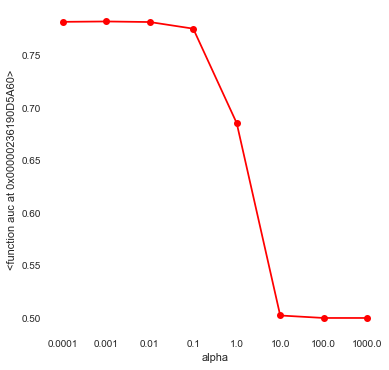

In [17]:
bestModel, bestScore, allModels, allScores =pf.bestFit(SGDClassifier(),paramgrid,standard_train_data,reviews,standard_cv_data,reviews_cv,metric=roc_auc_score,scoreLabel=auc,)

In [18]:
print(bestScore,bestModel)

0.781899529162 SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=100000,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


In [19]:
sdg_class=SGDClassifier(loss='hinge',penalty='l2',alpha=0.0001)

In [20]:
sdg_class.fit(standard_train_data,reviews)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [21]:
prediction=sdg_class.predict(standard_test_data)

# Prediction and Evaluation

In [22]:
print(classification_report(test_review,prediction))

             precision    recall  f1-score   support

          0       0.63      0.59      0.61      5026
          1       0.92      0.93      0.92     24974

avg / total       0.87      0.87      0.87     30000



In [23]:
confu_metric=confusion_matrix(test_review,prediction)
print(confu_metric)

[[ 2987  2039]
 [ 1756 23218]]


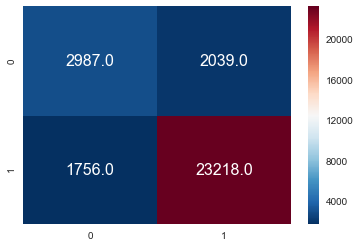

In [24]:
sns.heatmap(confu_metric,annot=True,fmt='.1f',annot_kws={"size": 16},cmap='RdBu_r')

# Train and Test Metric

In [25]:
TP=confu_metric[1][1]
FP=confu_metric[0][1]
TN=confu_metric[0][0]
FN=confu_metric[1][0]

In [26]:
True_positive_rate=TP/(TP+FN) #It tells us when it is actually a Positive Review , How often does it predict Postive Review
print('TPR: ',True_positive_rate)

false_positive_rate=FP/(FP+TN) # It tells us that when the review is negative how often does it predict Positive Review
print('FPR: ',false_positive_rate)

specificity=TN/(TN+FP) #It tells us that When the review is negative ,how often does it predict negative review
print('Specificity: ',specificity)

precision=TP/(TP+FP) # It tells us all the reviews that model has predicted to be Positive how many are truly positive 
print('Precision: ',precision)

recall=TP/(TP+FN) # It tells us that from all the predicted postive reviews how many are actually postive review
print('Recall: ',recall)

f1_score=2*precision*recall/(precision+recall) #It is the weighted average of the Precision and Recall
print('F1Score: ',f1_score)

TPR:  0.929686874349
FPR:  0.405690409869
Specificity:  0.594309590131
Precision:  0.919269905373
Recall:  0.929686874349
F1Score:  0.92444904541


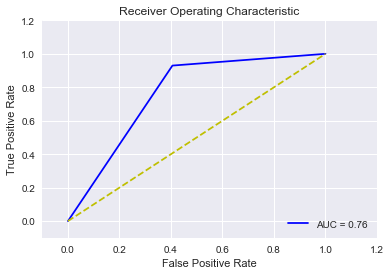

In [27]:
from sklearn.metrics import roc_curve,auc
fpr,tpr,thresholds=roc_curve(test_review,prediction)
roc_auc=auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'y--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Conclusion / Observation

1.I have preprocessed and cleaned  the whole dataset and store in Amazon.csv file for the further use. That CSV contains all the data. 
2. Now We have cleaned data , So I have sorted the Whole data on the basic of the TimeStamp
3. Now I have splitted my whole Dataset into Training,Cross validation and Test datasets for My ML
4. I have taken the 70K sample from the Training purpose and 30K Sample for Testing purpose and another 30K for cross validation
5. Its time to convert our text into vectors . I have used CountVectorizer() to convert my text reviews into Vectors . 
   I have converted the Training Sample ,cross validation sample and  Test sample individually

6. I have performed the column Standardization on my Training,Cross validation and Test data
7. First I have used GridSearchCV to find the best gamma and c value but , what i found it keeps on running through out the night.
   I found running SVM using GridSearchCV is very time consummimg so I have applied one of the best optimization algorithm SGDClassifier()
8. Now , I have used , ParameterGrid() to find the best value of the alpha. I have used bestfit() present in the parfit() package that give the best parameter ,score
   and it is very fast. Now I have got the best parameter value
9. I have applied SGDClassifier() using best parameter. 
10. I have predicted and evaluated the test data using classificationreport and confusion matrix
11. I have also found different test and train metric and on the basic of that I have drawn Roc cuve 

    

In [48]:
C_range = 10. ** np.arange(-2, 3)
gamma_range = 10. ** np.arange(-2, 3)
param_grid = dict(gamma=gamma_range, C=C_range)

In [ ]:
grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=3
grid.fit(standard_cv_data, reviews_cv)

In [28]:
scv_classifier = SVC(kernel='rbf')

In [29]:
scv_classifier.fit(standard_train_data,reviews)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Prediction and Evaluation

In [30]:
prediction_scv=scv_classifier.predict(standard_test_data)

In [31]:
print(classification_report(test_review,prediction_scv))

             precision    recall  f1-score   support

          0       0.92      0.24      0.38      5026
          1       0.87      1.00      0.93     24974

avg / total       0.88      0.87      0.83     30000



In [32]:
confu_metric_scv=confusion_matrix(test_review,prediction_scv)
print(confu_metric_scv)

[[ 1195  3831]
 [  107 24867]]


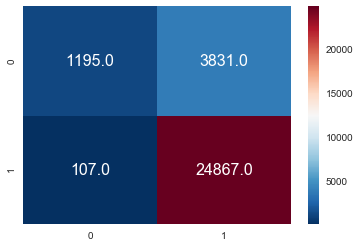

In [33]:
sns.heatmap(confu_metric_scv,annot=True,fmt='.1f',annot_kws={"size": 16},cmap='RdBu_r')

# Test and Train Metric

In [34]:
TP=confu_metric_scv[1][1]
FP=confu_metric_scv[0][1]
TN=confu_metric_scv[0][0]
FN=confu_metric_scv[1][0]

In [35]:
True_positive_rate=TP/(TP+FN) #It tells us when it is actually a Positive Review , How often does it predict Postive Review
print('TPR: ',True_positive_rate)

false_positive_rate=FP/(FP+TN) # It tells us that when the review is negative how often does it predict Positive Review
print('FPR: ',false_positive_rate)

specificity=TN/(TN+FP) #It tells us that When the review is negative ,how often does it predict negative review
print('Specificity: ',specificity)

precision=TP/(TP+FP) # It tells us all the reviews that model has predicted to be Positive how many are truly positive 
print('Precision: ',precision)

recall=TP/(TP+FN) # It tells us that from all the predicted postive reviews how many are actually postive review
print('Recall: ',recall)

f1_score=2*precision*recall/(precision+recall) #It is the weighted average of the Precision and Recall
print('F1Score: ',f1_score)

TPR:  0.995715544166
FPR:  0.762236370871
Specificity:  0.237763629129
Precision:  0.866506376751
Recall:  0.995715544166
F1Score:  0.926628409599


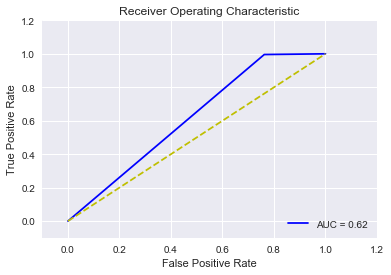

In [36]:
from sklearn.metrics import roc_curve,auc
fpr,tpr,thresholds=roc_curve(test_review,prediction_scv)
roc_auc=auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'y--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()